In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing, basinhopping
import os 
from scipy.fftpack import rfft, irfft, fftfreq, fft

In [2]:
import skfda 

In [3]:
if not os.path.exists('deconv'):
    os.mkdir('deconv')

In [5]:
def wiener_deconvolution(signal, kernel, lambd):
	"lambd is the SNR"
	kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
	H = fft(kernel)
	deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
	return deconvolved

In [6]:
def smooth_signal(y, thresh=100):
    signal = rfft(y)
    signal[thresh:] = 0
    resignal = irfft(signal)
    return resignal


if not os.path.exists('deconv'):
    os.mkdir('deconv')
for country in os.listdir('data'):
    if country != 'owid-covid-data.xlsx':
        SEIR_outputs =  pd.read_csv('data/' + country)# pd.read_csv('noisy_seir_results.csv')
        #true_incidence =  SEIR_outputs['true_incidence'].to_numpy()
        symptomatic_incidence =  SEIR_outputs['new_cases_per_million'].to_numpy()#SEIR_outputs['symptomatic_incidence'].to_numpy()#SEIR_outputs['new_cases_per_million'].to_numpy()#SEIR_outputs['symptomatic_incidence'].to_numpy()

        true_kernel = pd.read_csv('incubation_interval.csv')['pdf']# 'serial_interval.csv')['si']#'incubation_interval.csv')['pdf']

        weiner_deconvolved = wiener_deconvolution(symptomatic_incidence, true_kernel, 0.3)



        plt.figure(figsize=(20, 10))
        L = (len(true_kernel)-1)


        plt.plot(symptomatic_incidence[L:], label='symptomatic')

        plt.plot(weiner_deconvolved[L:], label='weiner deconv.')
        plt.plot(np.convolve(weiner_deconvolved, true_kernel, mode='valid'), label='reconstruct')
        plt.title(country)
        plt.legend()
        plt.savefig('figures/'+ country +'deconv.png')
        plt.show()

        test_df = pd.DataFrame()
        test_df['i'] =range(len(weiner_deconvolved))#range(len(xs.x))
        test_df['deconv'] = weiner_deconvolved#xs.x
        test_df['symptomatic'] = symptomatic_incidence#[L:]
        test_df.to_csv('deconv/'+country, index=False)

303


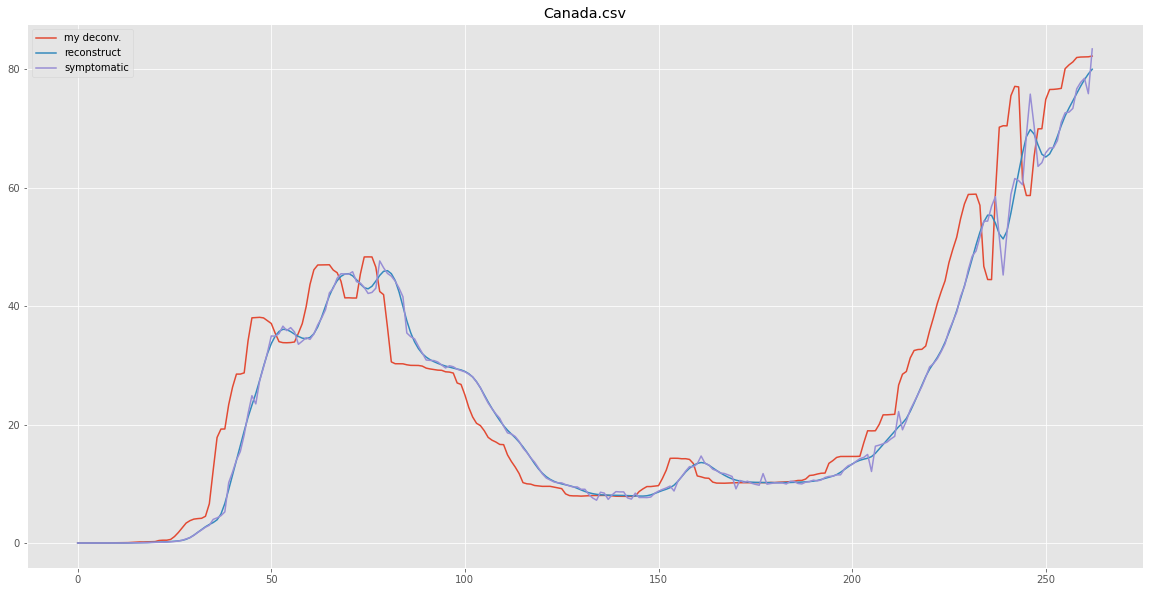

303


KeyboardInterrupt: 

In [14]:
if not os.path.exists('deconv_mine'):
    os.mkdir('deconv_mine')

for country in os.listdir('data'):
    if country != 'owid-covid-data.xlsx':
        SEIR_outputs =  pd.read_csv('data/' + country)# pd.read_csv('noisy_seir_results.csv')
        #true_incidence =  SEIR_outputs['true_incidence'].to_numpy()
        symptomatic_incidence =  SEIR_outputs['new_cases_per_million'].rolling(7).mean().to_numpy()[7:]#SEIR_outputs['symptomatic_incidence'].to_numpy()#SEIR_outputs['new_cases_per_million'].to_numpy()
        print(len(symptomatic_incidence))#SEIR_outputs['symptomatic_incidence'].to_numpy()
    
        true_kernel = pd.read_csv('incubation_interval.csv')['pdf']# 'serial_interval.csv')['si']#'incubation_interval.csv')['pdf']


        def optimizer_function(real_incidence):
            convolved = np.convolve(real_incidence, true_kernel, mode='valid')
            scaled_convolved = convolved/np.max(symptomatic_incidence[len(true_kernel)-1:]) *1000000
            scaled_incidence = symptomatic_incidence[len(true_kernel)-1:]/np.max(symptomatic_incidence[len(true_kernel)-1:]) *1000000

            penalty = 1E10 * np.mean(np.abs(np.diff(real_incidence)/np.max(symptomatic_incidence[len(true_kernel)-1:])))


            return np.mean((scaled_convolved - scaled_incidence)**2)+ penalty



        x0 = symptomatic_incidence 
        xs = minimize(optimizer_function, x0, bounds = [(0, np.inf) for _ in x0],options={'maxiter':200000})
        #x0 = true_kernel['si'].to_numpy()


        plt.figure(figsize=(20, 10))
        L = (len(true_kernel)-1)
        plt.plot(xs.x[L:], label='my deconv.')
        plt.plot(np.convolve(xs.x, true_kernel, mode='valid'), label='reconstruct')
        plt.plot(symptomatic_incidence[L:], label='symptomatic')
        plt.title(country)
        plt.legend()
        plt.savefig('figures/'+ country +'deconv_mine.png')
        plt.show()

        test_df = pd.DataFrame()
        test_df['i'] =range(len(xs.x))
        test_df['deconv'] = xs.x
        test_df['symptomatic'] = symptomatic_incidence#[L:]
        test_df.to_csv('deconv_mine/'+country, index=False)